# Model de Predictie multiparametru
https://www.kaggle.com/ironfrown/deep-learning-house-price-prediction-keras

In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model



kc_data_org = pd.read_csv("data/kc_house_data.csv")



kc_data_org['sale_yr'] = pd.to_numeric(kc_data_org.date.str.slice(0, 4))
kc_data_org['sale_month'] = pd.to_numeric(kc_data_org.date.str.slice(4, 6))
kc_data_org['sale_day'] = pd.to_numeric(kc_data_org.date.str.slice(6, 8))

kc_data = pd.DataFrame(kc_data_org, columns=[
        'sale_yr','sale_month','sale_day',
        'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
        'condition','grade','sqft_above','sqft_basement','yr_built',
        'zipcode','lat','long','sqft_living15','sqft_lot15','price'])
label_col = 'price'

print(kc_data.describe())



def train_validate_test_split(df, train_part=.6, validate_part=.2, test_part=.2, seed=None):
    np.random.seed(seed)
    total_size = train_part + validate_part + test_part
    train_percent = train_part / total_size
    validate_percent = validate_part / total_size
    test_percent = test_part / total_size
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = perm[:train_end]
    validate = perm[train_end:validate_end]
    test = perm[validate_end:]
    return train, validate, test

train_size, valid_size, test_size = (70, 30, 0)

kc_train, kc_valid, kc_test = train_validate_test_split(kc_data, 
                              train_part=train_size, 
                              validate_part=valid_size,
                              test_part=test_size,
                              seed=2017)



kc_y_train = kc_data.loc[kc_train, [label_col]]
kc_x_train = kc_data.loc[kc_train, :].drop(label_col, axis=1)
kc_y_valid = kc_data.loc[kc_valid, [label_col]]
kc_x_valid = kc_data.loc[kc_valid, :].drop(label_col, axis=1)

print('Size of training set: ', len(kc_x_train))
print('Size of validation set: ', len(kc_x_valid))
print('Size of test set: ', len(kc_test), '(not converted)')


def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)



def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df


stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])


Using TensorFlow backend.


            sale_yr    sale_month      sale_day      bedrooms     bathrooms  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean    2014.322954      6.574423     15.688197      3.370842      2.114757   
std        0.467616      3.115308      8.635063      0.930062      0.770163   
min     2014.000000      1.000000      1.000000      0.000000      0.000000   
25%     2014.000000      4.000000      8.000000      3.000000      1.750000   
50%     2014.000000      6.000000     16.000000      3.000000      2.250000   
75%     2015.000000      9.000000     23.000000      4.000000      2.500000   
max     2015.000000     12.000000     31.000000     33.000000      8.000000   

        sqft_living      sqft_lot        floors     condition         grade  \
count  21613.000000  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean    2079.899736  1.510697e+04      1.494309      3.409430      7.656873   
std      918.440897  4.142051e+04      0.539989    

In [2]:


def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)


def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    print(t_model.summary())
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)



def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)



In [3]:


model = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()



epochs = 500
batch_size = 128

print('Epochs: ', epochs)
print('Batch size: ', batch_size)




keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]



history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)




train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))




def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return



W0917 08:32:11.552551  7632 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 08:32:11.608703  7632 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 08:32:11.613699  7632 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0917 08:32:11.653204  7632 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default in

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                1520      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

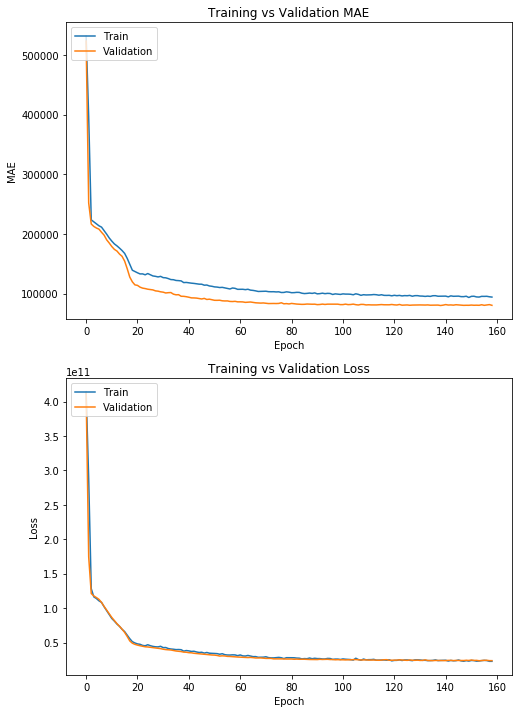

In [5]:


plot_hist(history.history, xsize=8, ysize=12)



In [13]:


for i in range(10):
    p = model.predict(arr_x_train[i].reshape(1, 18))
    print(p, arr_y_train[i], p/float(arr_y_train[i]))

[[249370.44]] [200000.] [[1.2468522]]
[[798930.6]] [350000.] [[2.2826588]]
[[249803.64]] [254000.] [[0.9834789]]
[[215656.28]] [175000.] [[1.2323216]]
[[575204.4]] [619000.] [[0.9292478]]
[[317811.1]] [240000.] [[1.3242129]]
[[263055.22]] [158000.] [[1.6649065]]
[[193060.7]] [200000.] [[0.96530354]]
[[280533.4]] [275000.] [[1.0201215]]
[[660163.5]] [593500.] [[1.1123227]]


In [14]:
arr_x_train[1].shape

(18,)